<h3>New York Taxi Duration Prediction</h3>

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

#### Import and setup mlflow

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location=('/Users/chuksokoli/Documents/mlops zoomcamp 2024/02 - Experiment '
 'Tracking/mlruns/1'), creation_time=1716367703627, experiment_id='1', last_update_time=1716367703627, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

#### Train model using Linear Regression and run manual mlflow experiment

In [3]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [4]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829445

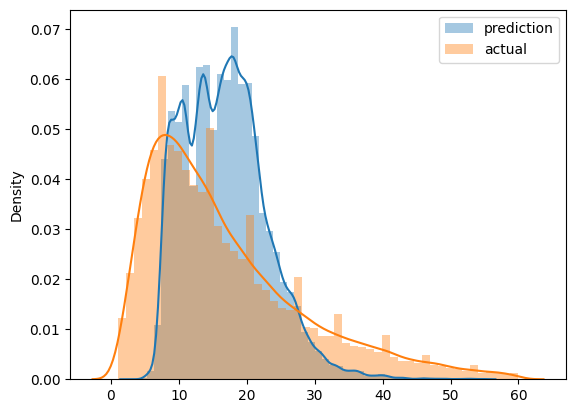

In [5]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [6]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [8]:
len(df_train), len(df_val)

(73908, 61921)

In [9]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715208946364

In [13]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [14]:
# train the model and add tracking in mlflow
with mlflow.start_run():
    mlflow.set_tag("developer", "chuks")
    mlflow.log_param("train-data-path", "'./data/green_tripdata_2021-01.parquet'")
    mlflow.log_param("valid-data-path", "'./data/green_tripdata_2021-02.parquet'")

    alpha = 0.001
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    # saving the model as an artifact - method 1
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle") # log model artifact

#### Train XGBoost and manually track with hyperparameter tuning

In [15]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [16]:
# change dataset format to DMatrix as per XGBOOST required format
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [17]:


# define objective function to use in hyperopt method fmin
def objective(params):
    with mlflow.start_run(): # tracks for each iteration
        mlflow.set_tag("model", "xgboost") # set tag
        mlflow.set_tag("developers", "chuks") 
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50,
            verbose_eval = False # show or not show the output
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}


In [18]:
# hyper parameter tuning and logging information from each iteration to mlflow
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

100%|██████████| 50/50 [26:12<00:00, 31.44s/trial, best loss: 6.307711258522687] 


In [19]:
# show best result
best_result

{'learning_rate': 0.09568805338197599,
 'max_depth': 38.0,
 'min_child_weight': 1.836115532320603,
 'reg_alpha': 0.01036217666199656,
 'reg_lambda': 0.014397849091965849}

In [20]:
best_result['max_depth'] = int(best_result['max_depth'])

#### Train XGBoost and track with mlflow autolog

In [21]:
# Perform automatic logging with mlflow
params = best_result
mlflow.xgboost.autolog(silent=True) # performs automatic logging

with mlflow.start_run(): # start tracking
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
    mlflow.set_tag("model", "xgboost") # set tag
    mlflow.set_tag("developers", "chuks") # set tag
    mlflow.set_tag("logtype", "auto") # set tag
    mlflow.log_params(params)
    
    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50,
        verbose_eval = False # suppress the output
    )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)    

In [22]:
# logging and saving model as an artifact
params = best_result
mlflow.xgboost.autolog(silent=True, disable=True) # disable automatic logging

with mlflow.start_run(): # start tracking
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
    mlflow.set_tag("model", "xgboost") # set tag
    mlflow.set_tag("developers", "chuks") # set tag
    mlflow.set_tag("logtype", "auto") # set tag
    mlflow.log_params(params)
    
    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50,
        verbose_eval = False # suppress the output
    )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)    

    # saving the dict vectorizer as an artifact
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    # save model as an artifact - method 2
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow") # log model artifact

In [23]:
# loading the model as a python function
logged_model = 'runs:/1677c63ee9ce40b0a5fd4ec1efed1572/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 1677c63ee9ce40b0a5fd4ec1efed1572

In [24]:
# loading the model using xgboost flavor
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

In [25]:
# making prediction
y_pred = xgboost_model.predict(valid)
y_pred[:10]

array([14.484921,  7.237496, 15.57976 , 24.462515,  9.37887 , 17.144417,
       11.579966,  7.844187,  9.021971, 18.948055], dtype=float32)

#### Train multiple model and track with mlflow autologging

In [28]:
import sys
import logging
import shap
import numpy as np
import mlflow.sklearn
import mlflow.lightgbm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt

# Suppress logging messages
logging.getLogger("mlflow").setLevel(logging.ERROR)
logging.getLogger("lightgbm").setLevel(logging.ERROR)
logging.getLogger("shap").setLevel(logging.ERROR)

# Suppress stderr output
class SuppressStdErr:
    def __enter__(self):
        self.stderr = sys.stderr
        sys.stderr = open('/dev/null', 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stderr.close()
        sys.stderr = self.stderr

# Define the LightGBM regressor
LGBMRegressor = lgb.LGBMRegressor

# List of model classes
models = [LGBMRegressor, RandomForestRegressor, GradientBoostingRegressor]

Running model: LGBMRegressor
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1383
[LightGBM] [Info] Number of data points in the train set: 73908, number of used features: 565
[LightGBM] [Info] Start training from score 16.852578


Failed to log feature importance plot for LGBMRegressor: index 8724 is out of bounds for axis 0 with size 1
Running model: RandomForestRegressor
Running model: GradientBoostingRegressor
Error in callback <function _draw_all_if_interactive at 0x13f5da5e0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 640x132690 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 640x132690 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x132690 with 1 Axes>

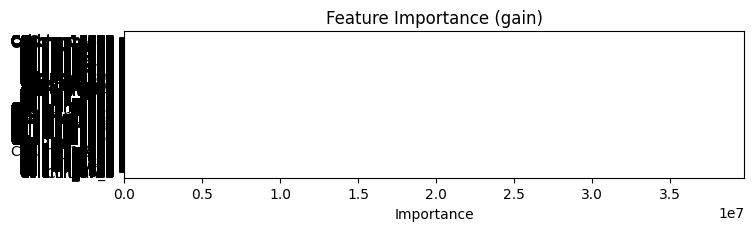

In [29]:
# Auto log all MLflow entities
mlflow.autolog()
mlflow.lightgbm.autolog()

for model_class in models:
    print(f'Running model: {model_class.__name__}')
    with mlflow.start_run(): # tracks for each model

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.set_tag("model", f"{model_class.__name__}") # set tag
        mlflow.set_tag("developers", "chuks") # set tag
        mlflow.set_tag("logtype", "auto") # set tag

        # Initialize and fit the model
        with SuppressStdErr():
            mlmodel = model_class()
            mlmodel.fit(X_train, y_train)

        # Predict and log RMSE
        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

        # Log feature importance for LightGBM only
        if model_class == LGBMRegressor:
            try:
                # Plot feature importance
                shap.initjs()
                explainer = shap.TreeExplainer(mlmodel)
                shap_values = explainer.shap_values(X_train, approximate=False)

                shap.summary_plot(shap_values, X_train, show=False, plot_type="bar")
                fig, ax = plt.gcf(), plt.gca()
                fig.set_size_inches(8, 6)

                # Modifying main plot parameters
                ax.tick_params(labelsize=14)
                ax.set_xlabel("SHAP value (impact on model output)", fontsize=10)
                ax.set_title(f"Feature Importance - {model_class.__name__} model on features", fontsize=12)

                # Modifying color bar parameters
                ax.tick_params(labelsize=10)
                ax.set_ylabel("Feature value", fontsize=10)
                plt.tight_layout()

                # Save plot to file and log it
                plt.savefig("feature_importance.png")
                mlflow.log_artifact("feature_importance.png")
                plt.close()
            except Exception as e:
                print(f"Failed to log feature importance plot for {model_class.__name__}: {e}")

#### Interacting Programmatically with `mlflow.client`

We can use `mlflow.client` to interact with our experiment and decide which model should be promoted to Staging.

In [30]:
# import the mlflow.client class
from mlflow.tracking import MlflowClient

# initialize the client
MLFLOW_TRACK_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACK_URI) # access artifact models

In [32]:
# List all experiments using mlflow.search_experiments method
experiments = client.search_experiments()
experiments

[<Experiment: artifact_location=('/Users/chuksokoli/Documents/mlops zoomcamp 2024/02 - Experiment '
  'Tracking/mlruns/1'), creation_time=1716367703627, experiment_id='1', last_update_time=1716367703627, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1716366063778, experiment_id='0', last_update_time=1716366063778, lifecycle_stage='active', name='Default', tags={}>]

In [36]:
# get best runs, filter runs and order by rmse
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',
    filter_string="metrics.rmse < 6.8",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
)

In [37]:
runs

[<Run: data=<RunData: metrics={'rmse': 6.304847662239386}, params={'learning_rate': '0.1752375182528613',
  'max_depth': '23',
  'min_child_weight': '1.415228552488043',
  'reg_alpha': '0.09414733746951101',
  'reg_lambda': '0.10507309746262047',
  'train-data-path': './data/green_tripdata_2021-01.csv',
  'valid-data-path': './data/green_tripdata_2021-02.csv'}, tags={'developers': 'chuks',
  'logtype': 'auto',
  'mlflow.log-model.history': '[{"run_id": "1677c63ee9ce40b0a5fd4ec1efed1572", '
                              '"artifact_path": "models_mlflow", '
                              '"utc_time_created": "2024-05-23 '
                              '05:54:50.793300", "flavors": {"python_function": '
                              '{"loader_module": "mlflow.xgboost", '
                              '"python_version": "3.9.19", "data": "model.xgb", '
                              '"env": {"conda": "conda.yaml", "virtualenv": '
                              '"python_env.yaml"}}, "xgboost":

In [38]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: 1677c63ee9ce40b0a5fd4ec1efed1572, rmse: 6.3048
run id: f04a28680d7046fd8b3eaff375d5fc52, rmse: 6.3048
run id: c990a5a754be404699efdffe0d34b70c, rmse: 6.3048
run id: 99aa83dcdb1b48218adabd926d61dc5f, rmse: 6.3048
run id: 78f57642172142849e89d53ea1ff753d, rmse: 6.3056


In [39]:
# promote model to model registry
mlflow.set_tracking_uri(MLFLOW_TRACK_URI)

run_id = 'f04a28680d7046fd8b3eaff375d5fc52'
model_uri = f"runs:/{run_id}/model"

# register a new version of the model in mlflow
mlflow.register_model(model_uri=model_uri, name='nyc-taxi-regressor')

Registered model 'nyc-taxi-regressor' already exists. Creating a new version of this model...
Created version '5' of model 'nyc-taxi-regressor'.


<ModelVersion: aliases=[], creation_timestamp=1716536987139, current_stage='None', description=None, last_updated_timestamp=1716536987139, name='nyc-taxi-regressor', run_id='f04a28680d7046fd8b3eaff375d5fc52', run_link=None, source=('/Users/chuksokoli/Documents/mlops zoomcamp 2024/02 - Experiment '
 'Tracking/mlruns/1/f04a28680d7046fd8b3eaff375d5fc52/artifacts/model'), status='READY', status_message=None, tags={}, user_id=None, version=5>

In [41]:
# get list of registered model
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1716450461447, description='', last_updated_timestamp=1716536987139, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1716455367925, current_stage='Archived', description='', last_updated_timestamp=1716535669082, name='nyc-taxi-regressor', run_id='4ca6535b22124d77a7309602a80a0cd3', run_link='', source=('/Users/chuksokoli/Documents/mlops zoomcamp 2024/02 - Experiment '
  'Tracking/mlruns/1/4ca6535b22124d77a7309602a80a0cd3/artifacts/model'), status='READY', status_message=None, tags={'model': 'lightgbm'}, user_id=None, version=2>,
  <ModelVersion: aliases=[], creation_timestamp=1716535619181, current_stage='Staging', description='This is NYC Taxi Prediction for trip duration', last_updated_timestamp=1716535746696, name='nyc-taxi-regressor', run_id='2a6016a71fff4cdbba9823381740b0ce', run_link='', source=('/Users/chuksokoli/Documents/mlops zoomcamp 2024/02 - Experiment '
  'Tracking/mlruns/1/2a6016a71fff4cdbba9823381740b0ce/ar

In [72]:
# get latest version of model
model_name = "nyc-taxi-regressor"
latest_version = client.get_latest_versions(name=model_name)

for version in latest_version:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 2, stage: Archived
version: 3, stage: Production
version: 5, stage: Staging


In [50]:
# transition model to a differnt stage
model_version=5
new_stage="Staging"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)


<ModelVersion: aliases=[], creation_timestamp=1716536987139, current_stage='Staging', description=None, last_updated_timestamp=1716617506846, name='nyc-taxi-regressor', run_id='f04a28680d7046fd8b3eaff375d5fc52', run_link=None, source=('/Users/chuksokoli/Documents/mlops zoomcamp 2024/02 - Experiment '
 'Tracking/mlruns/1/f04a28680d7046fd8b3eaff375d5fc52/artifacts/model'), status='READY', status_message=None, tags={}, user_id=None, version=5>

In [53]:
# update the model 
from datetime import datetime
date = datetime.today().date()

client.update_model_version(
    name=model_name, 
    version=5,
    description=f"This version of xgboost is version {model_version} but has since been updated by version 3 and has been transitioned to {new_stage} on {date}."

)

<ModelVersion: aliases=[], creation_timestamp=1716536987139, current_stage='Staging', description=('This version of xgboost is version 5 but has since been updated by version 3 '
 'and has been transitioned to Staging on 2024-05-24.'), last_updated_timestamp=1716617687433, name='nyc-taxi-regressor', run_id='f04a28680d7046fd8b3eaff375d5fc52', run_link=None, source=('/Users/chuksokoli/Documents/mlops zoomcamp 2024/02 - Experiment '
 'Tracking/mlruns/1/f04a28680d7046fd8b3eaff375d5fc52/artifacts/model'), status='READY', status_message=None, tags={}, user_id=None, version=5>

In [55]:
# read the data and remove outliers
def read_dataframe(filename: str):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

# preprocess the dataset
def preprocess(df, dv):
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    categorical = ['PU_DO']
    numerical = ['trip_distance']
    train_dicts = df[categorical + numerical].to_dict(orient='records')
    return dv.transform(train_dicts)

def test_model(name, stage, X_test, y_test):
    model = mlflow.pyfunc.load_model(f"models:/{name}/{stage}")
    y_pred = model.predict(X_test)
    return {"rmse": mean_squared_error(y_test, y_pred, squared=False)}

In [60]:
# using prebuilt function to decide which model to promote to Production with test data
df = read_dataframe("./data/green_tripdata_2021-03.parquet")
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-03-01 00:05:42,2021-03-01 00:14:03,N,1.0,83,129,1.0,1.56,7.5,...,0.5,0.00,0.0,None,0.3,8.80,1.0,1.0,0.0,8.350000
1,2,2021-03-01 00:21:03,2021-03-01 00:26:17,N,1.0,243,235,1.0,0.96,6.0,...,0.5,0.00,0.0,None,0.3,7.30,2.0,1.0,0.0,5.233333
2,2,2021-03-01 00:02:06,2021-03-01 00:22:26,N,1.0,75,242,1.0,9.93,28.0,...,0.5,2.00,0.0,None,0.3,31.30,1.0,1.0,0.0,20.333333
3,2,2021-03-01 00:24:03,2021-03-01 00:31:43,N,1.0,242,208,1.0,2.57,9.5,...,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.0,7.666667
4,1,2021-03-01 00:11:10,2021-03-01 00:14:46,N,1.0,41,151,1.0,0.80,5.0,...,0.5,1.85,0.0,None,0.3,8.15,1.0,1.0,0.0,3.600000


In [62]:
run_id = "05e0541c644b47d9b8ad9d88abeac50a"
client.download_artifacts(run_id=run_id, path="preprocessor", dst_path=".")

'/Users/chuksokoli/Documents/mlops zoomcamp 2024/02 - Experiment Tracking/preprocessor'

In [63]:
import pickle

with open("preprocessor/preprocessor.b", "rb") as f_in:
    dv = pickle.load(f_in)

In [64]:
X_test = preprocess(df, dv)

In [65]:
target = "duration"
y_test = df[target].values

In [68]:
%time test_model(name=model_name, stage="Staging", X_test=X_test, y_test=y_test)

CPU times: user 9.3 s, sys: 252 ms, total: 9.55 s
Wall time: 1.06 s


{'rmse': 6.261387453373405}

In [69]:
# promote v3 to Production"
model_version=3
new_stage="Production"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)


<ModelVersion: aliases=[], creation_timestamp=1716535584967, current_stage='Production', description='This is NYC Taxi Prediction for trip duration', last_updated_timestamp=1716625109688, name='nyc-taxi-regressor', run_id='05e0541c644b47d9b8ad9d88abeac50a', run_link='', source=('/Users/chuksokoli/Documents/mlops zoomcamp 2024/02 - Experiment '
 'Tracking/mlruns/1/05e0541c644b47d9b8ad9d88abeac50a/artifacts/models_mlflow'), status='READY', status_message=None, tags={'model': 'xgboost'}, user_id=None, version=3>

In [70]:
%time test_model(name=model_name, stage="Production", X_test=X_test, y_test=y_test)

CPU times: user 16.8 s, sys: 485 ms, total: 17.3 s
Wall time: 1.9 s


{'rmse': 6.261320092947898}

In [73]:
%time test_model(name=model_name, stage="Archived", X_test=X_test, y_test=y_test)

CPU times: user 1.14 s, sys: 4.77 ms, total: 1.15 s
Wall time: 1.16 s


{'rmse': 6.57164212164233}

In [74]:
# Since v2 performed OK, transition to Staging
model_version=2
new_stage="Staging"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

<ModelVersion: aliases=[], creation_timestamp=1716455367925, current_stage='Staging', description='', last_updated_timestamp=1716625446118, name='nyc-taxi-regressor', run_id='4ca6535b22124d77a7309602a80a0cd3', run_link='', source=('/Users/chuksokoli/Documents/mlops zoomcamp 2024/02 - Experiment '
 'Tracking/mlruns/1/4ca6535b22124d77a7309602a80a0cd3/artifacts/model'), status='READY', status_message=None, tags={'model': 'lightgbm'}, user_id=None, version=2>

In [75]:
# update the model description
client.update_model_version(
    name=model_name, 
    version=model_version,
    description=f"This lightgbm model v{model_version} has been transitioned from Archive to {new_stage} on {date}."
)

<ModelVersion: aliases=[], creation_timestamp=1716455367925, current_stage='Staging', description=('This lightgbm model v2 has been transitioned from Archive to Staging on '
 '2024-05-24.'), last_updated_timestamp=1716625640842, name='nyc-taxi-regressor', run_id='4ca6535b22124d77a7309602a80a0cd3', run_link='', source=('/Users/chuksokoli/Documents/mlops zoomcamp 2024/02 - Experiment '
 'Tracking/mlruns/1/4ca6535b22124d77a7309602a80a0cd3/artifacts/model'), status='READY', status_message=None, tags={'model': 'lightgbm'}, user_id=None, version=2>